In [1]:
import os
import numpy as np
import pandas as pd

from bidict import bidict
from tqdm import tqdm 

import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch
from matplotlib.collections import PatchCollection, LineCollection

In [2]:
data_dir = '/kaggle/input/yandex-cup-2023-neuroswipe'

In [3]:
vocab = bidict()
with open(os.path.join(data_dir, 'voc.txt'), 'r') as f:
    i = 0
    for word in tqdm(f):
        vocab[word.rstrip('\n')] = i
        i += 1
len(vocab)

503598it [00:07, 63834.10it/s]


503598

In [4]:
%%time
df_keyboards = pd.read_csv(os.path.join(data_dir, 'keyboards_full.csv'))
df_keys = pd.read_csv(os.path.join(data_dir, 'keys_full.csv'))

df_train_curves = pd.read_parquet(os.path.join(data_dir, 'train_curves.parquet'))
df_train_curves_info = pd.read_parquet(os.path.join(data_dir, 'train_curves_info.parquet'))

df_valid_curves = pd.read_parquet(os.path.join(data_dir, 'valid_curves.parquet'))
df_valid_curves_info = pd.read_parquet(os.path.join(data_dir, 'valid_curves_info.parquet'))

df_acc_curves = pd.read_parquet(os.path.join(data_dir, 'accepted_curves.parquet'))
df_acc_curves_info = pd.read_parquet(os.path.join(data_dir, 'accepted_curves_info.parquet'))

df_sug_curves = pd.read_parquet(os.path.join(data_dir, 'suggestion_accepted_curves.parquet'))
df_sug_curves_info = pd.read_parquet(os.path.join(data_dir, 'suggestion_accepted_curves_info.parquet'))

df_test_curves = pd.read_parquet(os.path.join(data_dir, 'test_curves.parquet'))
df_test_curves_info = pd.read_parquet(os.path.join(data_dir, 'test_curves_info.parquet'))

CPU times: user 34.6 s, sys: 1min 6s, total: 1min 41s
Wall time: 1min 10s


In [5]:
df_keyboards.set_index('id', inplace=True)
df_keys.set_index('keyboard_id', inplace=True)

In [6]:
all_df = [
    df_train_curves, df_train_curves_info,
    df_valid_curves, df_valid_curves_info, 
    df_acc_curves, df_acc_curves_info,
    df_sug_curves, df_sug_curves_info,
    df_test_curves, df_test_curves_info
]
for df in all_df:
    df.set_index('curve_id', inplace=True)

In [7]:
def plot_keyboard(keyboard, keys, word=''):
    width, height = keyboard[['width', 'height']].values

    fig = plt.figure(figsize=(30, 15))
    ax = fig.add_subplot(111)

    ax.set_xlim([0, width])
    ax.set_ylim([0, height])
    # ax.set_ylim([height, 0])
    
    fig.subplots_adjust(
        top=0.86,
        bottom=0.09,
        left=0.100,
        right=0.925,
        hspace=0.2,
        wspace=0.2
    )

    patches = []
    pressed_patches = []

    for _, key in keys.iterrows():
        # h = key.get('background', key.get('hitbox'))
        p = FancyBboxPatch(
            (key['hitbox_x'], key['hitbox_y']),
             key['hitbox_w'], key['hitbox_h'],
            boxstyle="round4",
            fc='powderblue',
            ec='black', 
            zorder=1,
        )
        label = key['label']
        if label and label in word:
            pressed_patches.append(p)
        else:
            patches.append(p)
        label = label if (label and (label.isalnum() or label.isascii())) else '@'
        ax.text(key['hitbox_x'] + 10, key['hitbox_y'] + key['hitbox_h'] - 10, label, fontsize=20)

    collection = PatchCollection(patches)
    collection.set_facecolor("powderblue")
    collection.set_edgecolor("black")
    ax.add_collection(collection)

    pressed_collection = PatchCollection(pressed_patches)
    pressed_collection.set_facecolor("bisque")
    pressed_collection.set_edgecolor("black")
    ax.add_collection(pressed_collection)
    return fig, ax

def get_key_center(key): #row from df_keys
    return (key['hitbox_x'] + key['hitbox_w'] / 2, key['hitbox_y'] + key['hitbox_h'] / 2)

def sy(y):
    return y / 1200 * height
    
def plot_swipe(
    # event, 
    curve, 
    keyboard, keys, 
    word, 
    plot_ideal_curve=False, 
    plot_speed=False, 
    # draw_only_reference=False
):
    width, height = keyboard[['width', 'height']].values
    label2center = dict()
    for _, key in keys.iterrows():
        if key['is_action']:
            continue
        cx, cy = get_key_center(key)
        label2center[key['label']] = (cx, cy)

    if 'ё' not in label2center:
        label2center['ё'] = label2center.get('е')

    if 'ъ' not in label2center:
        label2center['ъ'] = label2center.get('ь')

    word_lower = word.lower()
    ideal_curve_x = np.array([label2center[c][0] for c in word_lower if c in label2center])
    ideal_curve_y = np.array([label2center[c][1] for c in word_lower if c in label2center])

    fig, ax = plot_keyboard(keyboard, keys, word=word)

    x = curve['x'].values
    y = curve['y'].values
    t = curve['t'].values

    if not len(x):
        print(f"Empty event, skip it. Word={word}", file=sys.stderr)
        return fig, ax

    if plot_ideal_curve:
        ax.plot(ideal_curve_x, ideal_curve_y, linewidth=3, color='salmon')
    if plot_speed:
        dt = t[1:] - t[:-1] + 0.5
        v = np.linalg.norm(np.array([x, y]).T[1:] - np.array([x, y]).T[:-1], axis=1) / dt
        max_v = np.max(v)

        lwidths = 1 + (v / max_v) ** 0.5 * 10
        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)

        lc = LineCollection(segments, linewidths=lwidths, color='steelblue', zorder=10)
        ax.add_collection(lc)
    else:
        ax.plot(x, y, linewidth=3, color='steelblue')

    for i in range(len(x)):
        ax.text(x[i], y[i], i, fontsize=10, zorder=10, color='black')

    ax.plot(x[0], y[0], 'go', markersize=12)
    ax.plot(x[-1], y[-1], 'ro', markersize=12)

    ax.set_xlim([0, width])
    ax.set_ylim([height, 0])
    ax.set_title(word)
    
    return fig, ax

In [8]:
def plot_curve(curve_id, df_curves, df_info, is_test=False):
    global df_keyboards, df_keys
    curve = df_curves.loc[curve_id]
    
    if not is_test:
        keyboard_id, word_index = df_info.loc[curve_id, ['keyboard_id', 'word_index']].values
        word = vocab.inverse[word_index]
    else:
        keyboard_id = df_info.loc[curve_id, ['keyboard_id']].values[0]
        word = ''

    keyboard = df_keyboards.loc[keyboard_id]
    keys = df_keys.loc[keyboard_id]

    return plot_swipe(curve, keyboard, keys, word, plot_ideal_curve=True, plot_speed=True)

# Train

(<Figure size 3000x1500 with 1 Axes>, <Axes: title={'center': 'заходить'}>)

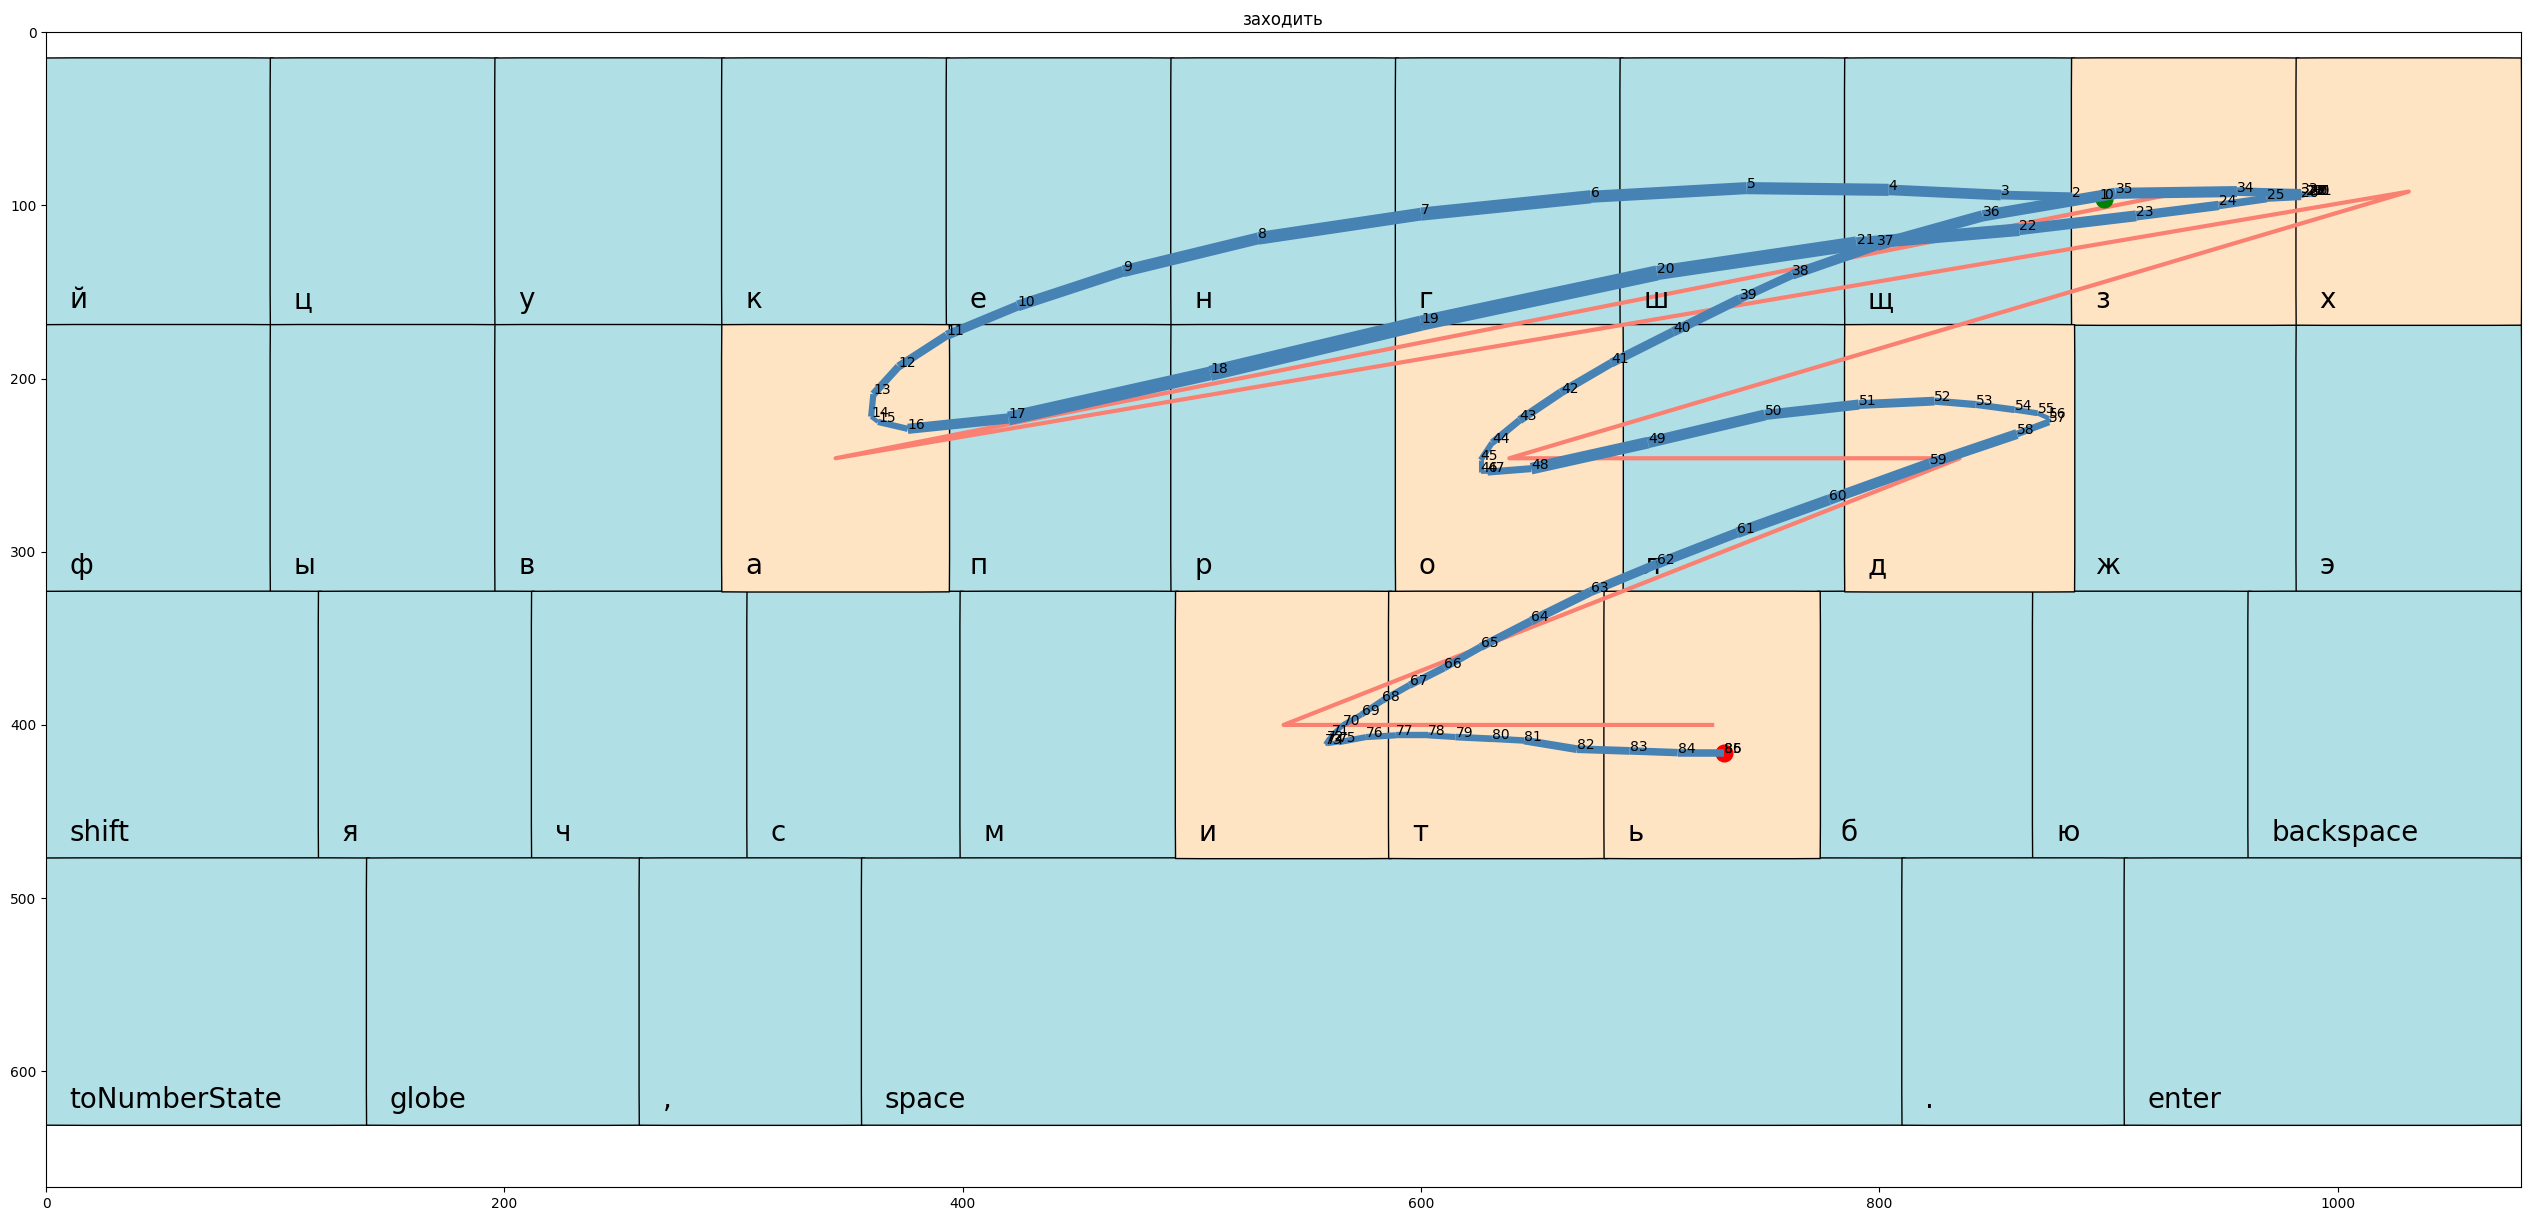

In [9]:
curve_id = 179
plot_curve(curve_id, df_train_curves, df_train_curves_info)

# Valid

(<Figure size 3000x1500 with 1 Axes>, <Axes: title={'center': 'сорян'}>)

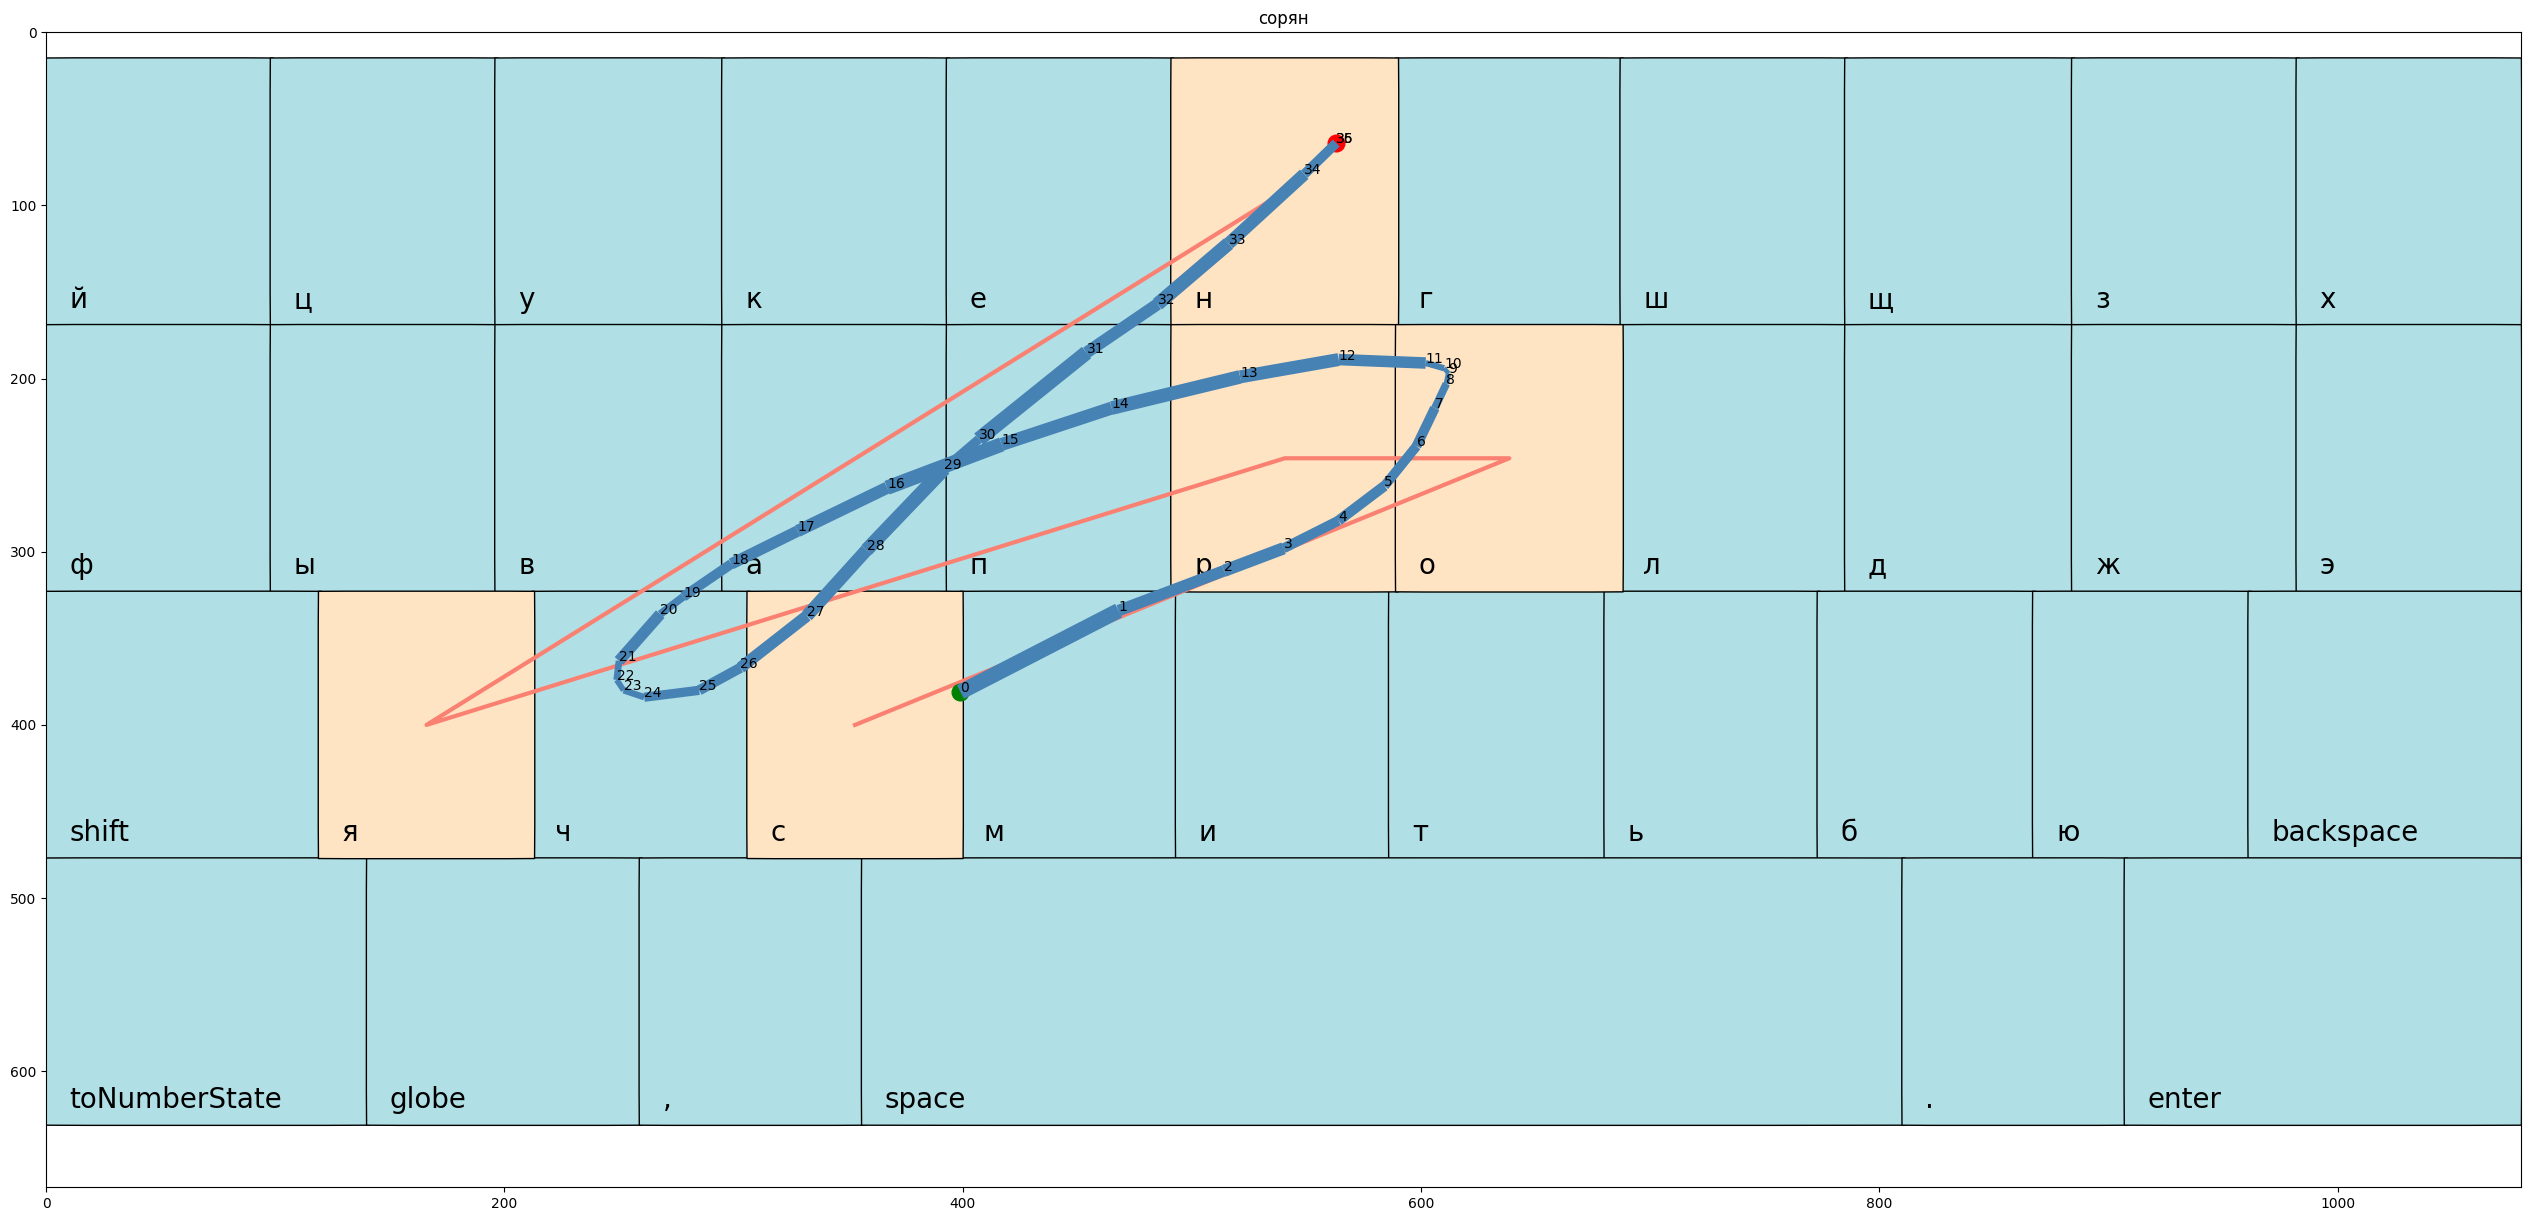

In [10]:
curve_id = 789
plot_curve(curve_id, df_valid_curves, df_valid_curves_info)

# Suggestion accepted

(<Figure size 3000x1500 with 1 Axes>, <Axes: title={'center': 'по-моему'}>)

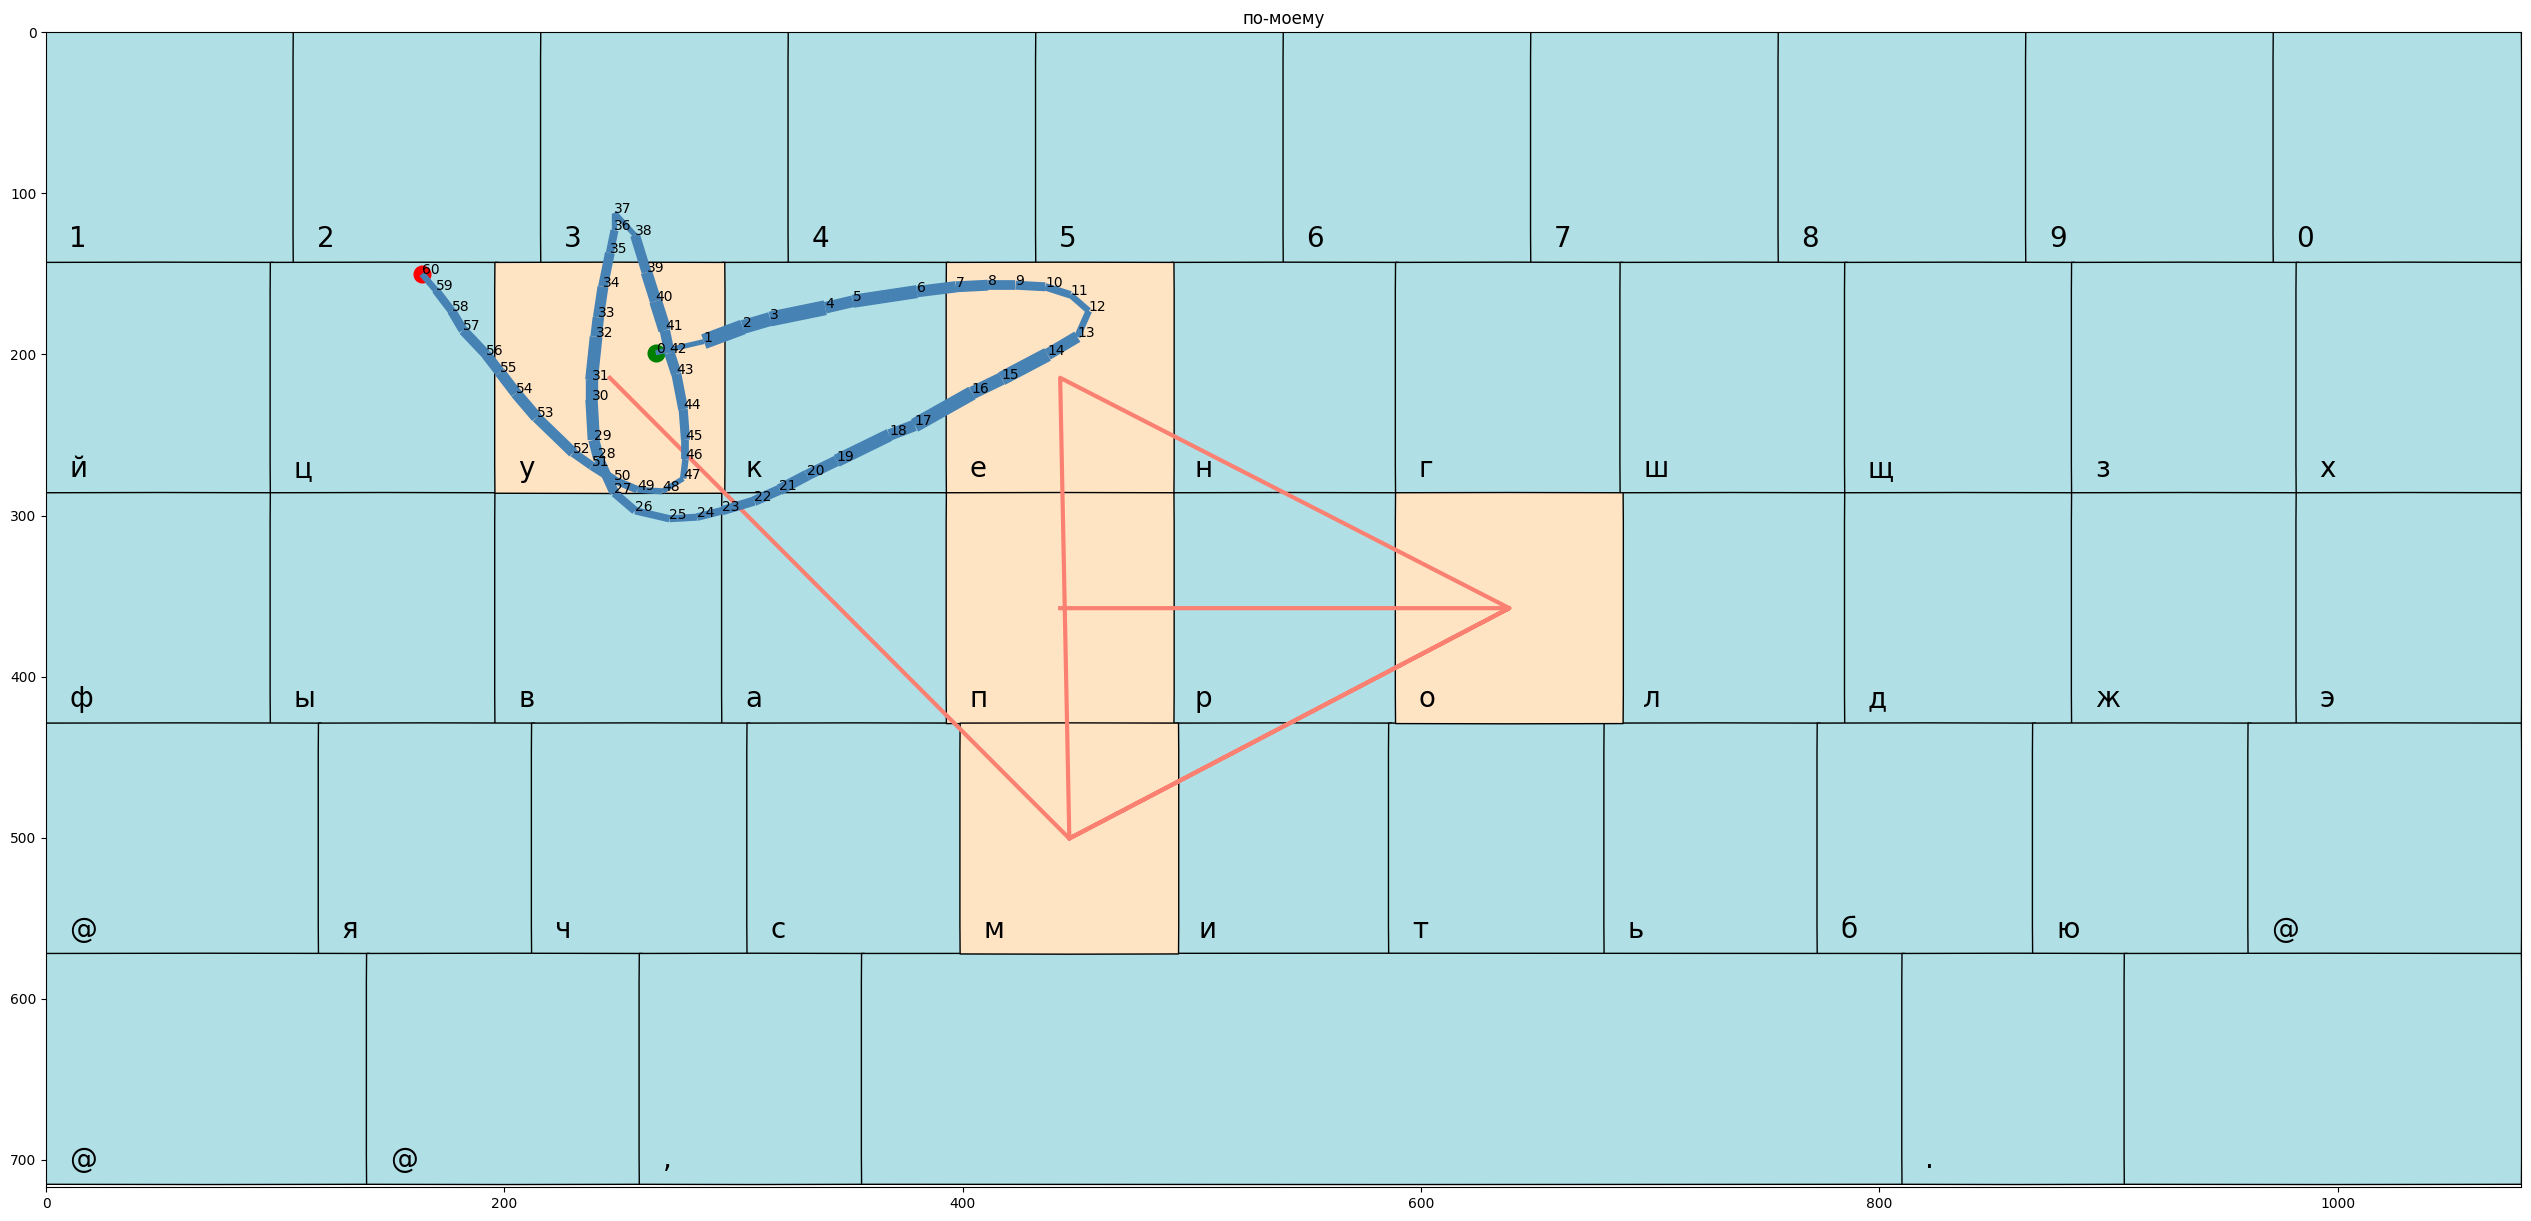

In [11]:
curve_id = 903010
plot_curve(curve_id, df_sug_curves, df_sug_curves_info)

# Accepted

(<Figure size 3000x1500 with 1 Axes>, <Axes: title={'center': 'проблем'}>)

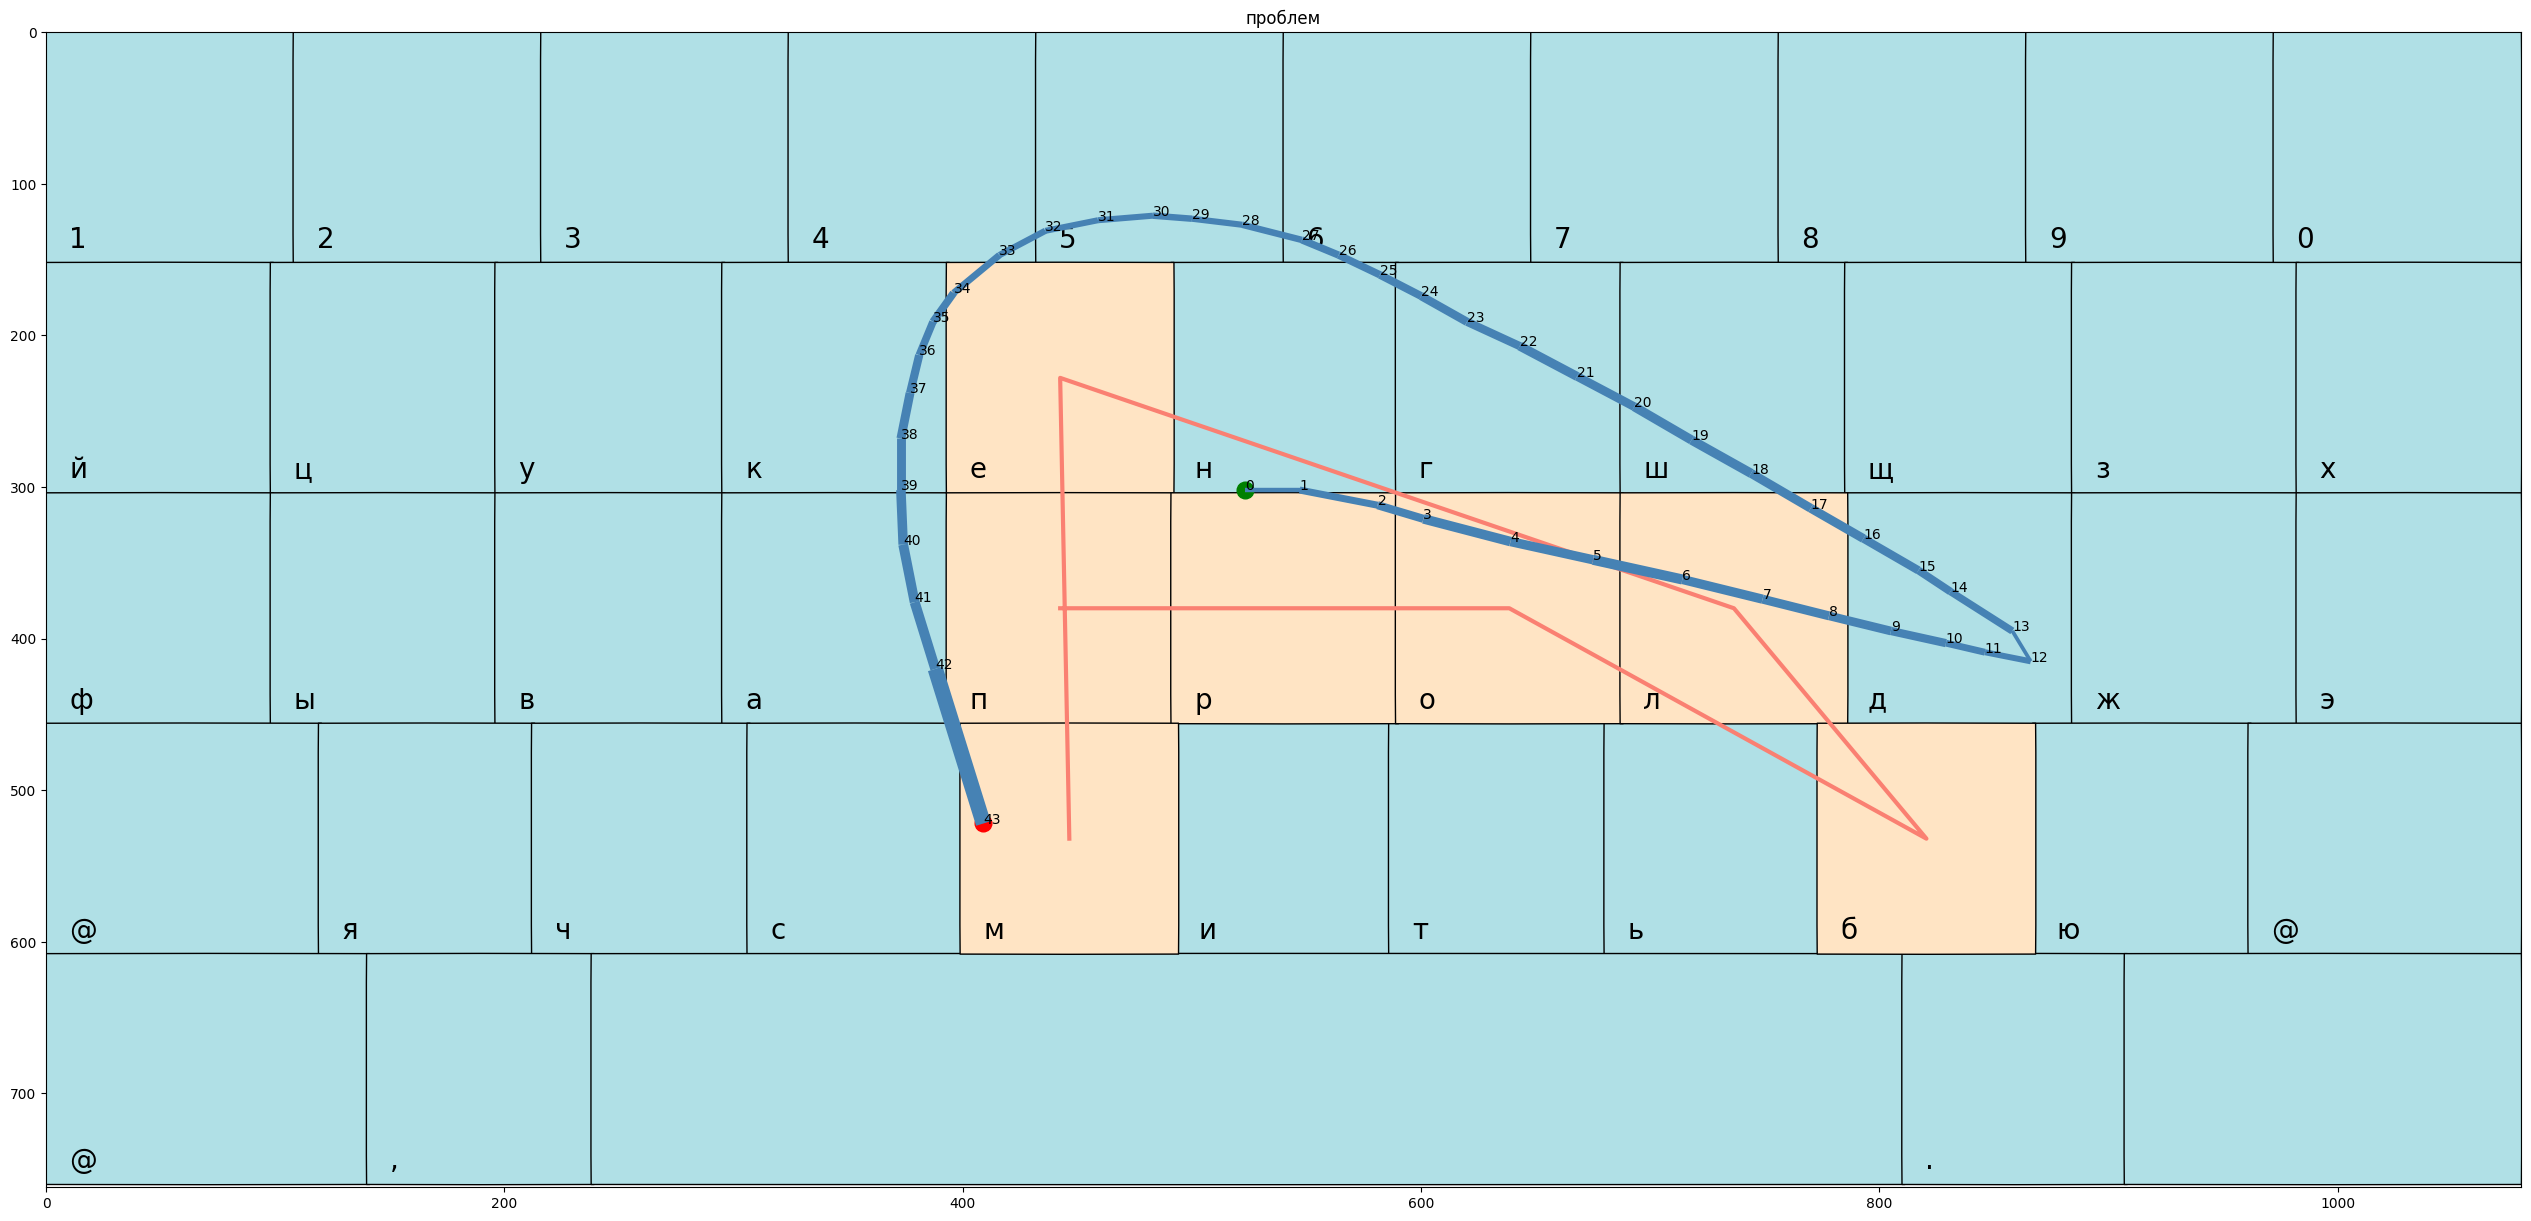

In [12]:
curve_id = 789
plot_curve(curve_id, df_acc_curves, df_acc_curves_info)

# Test

(<Figure size 3000x1500 with 1 Axes>, <Axes: >)

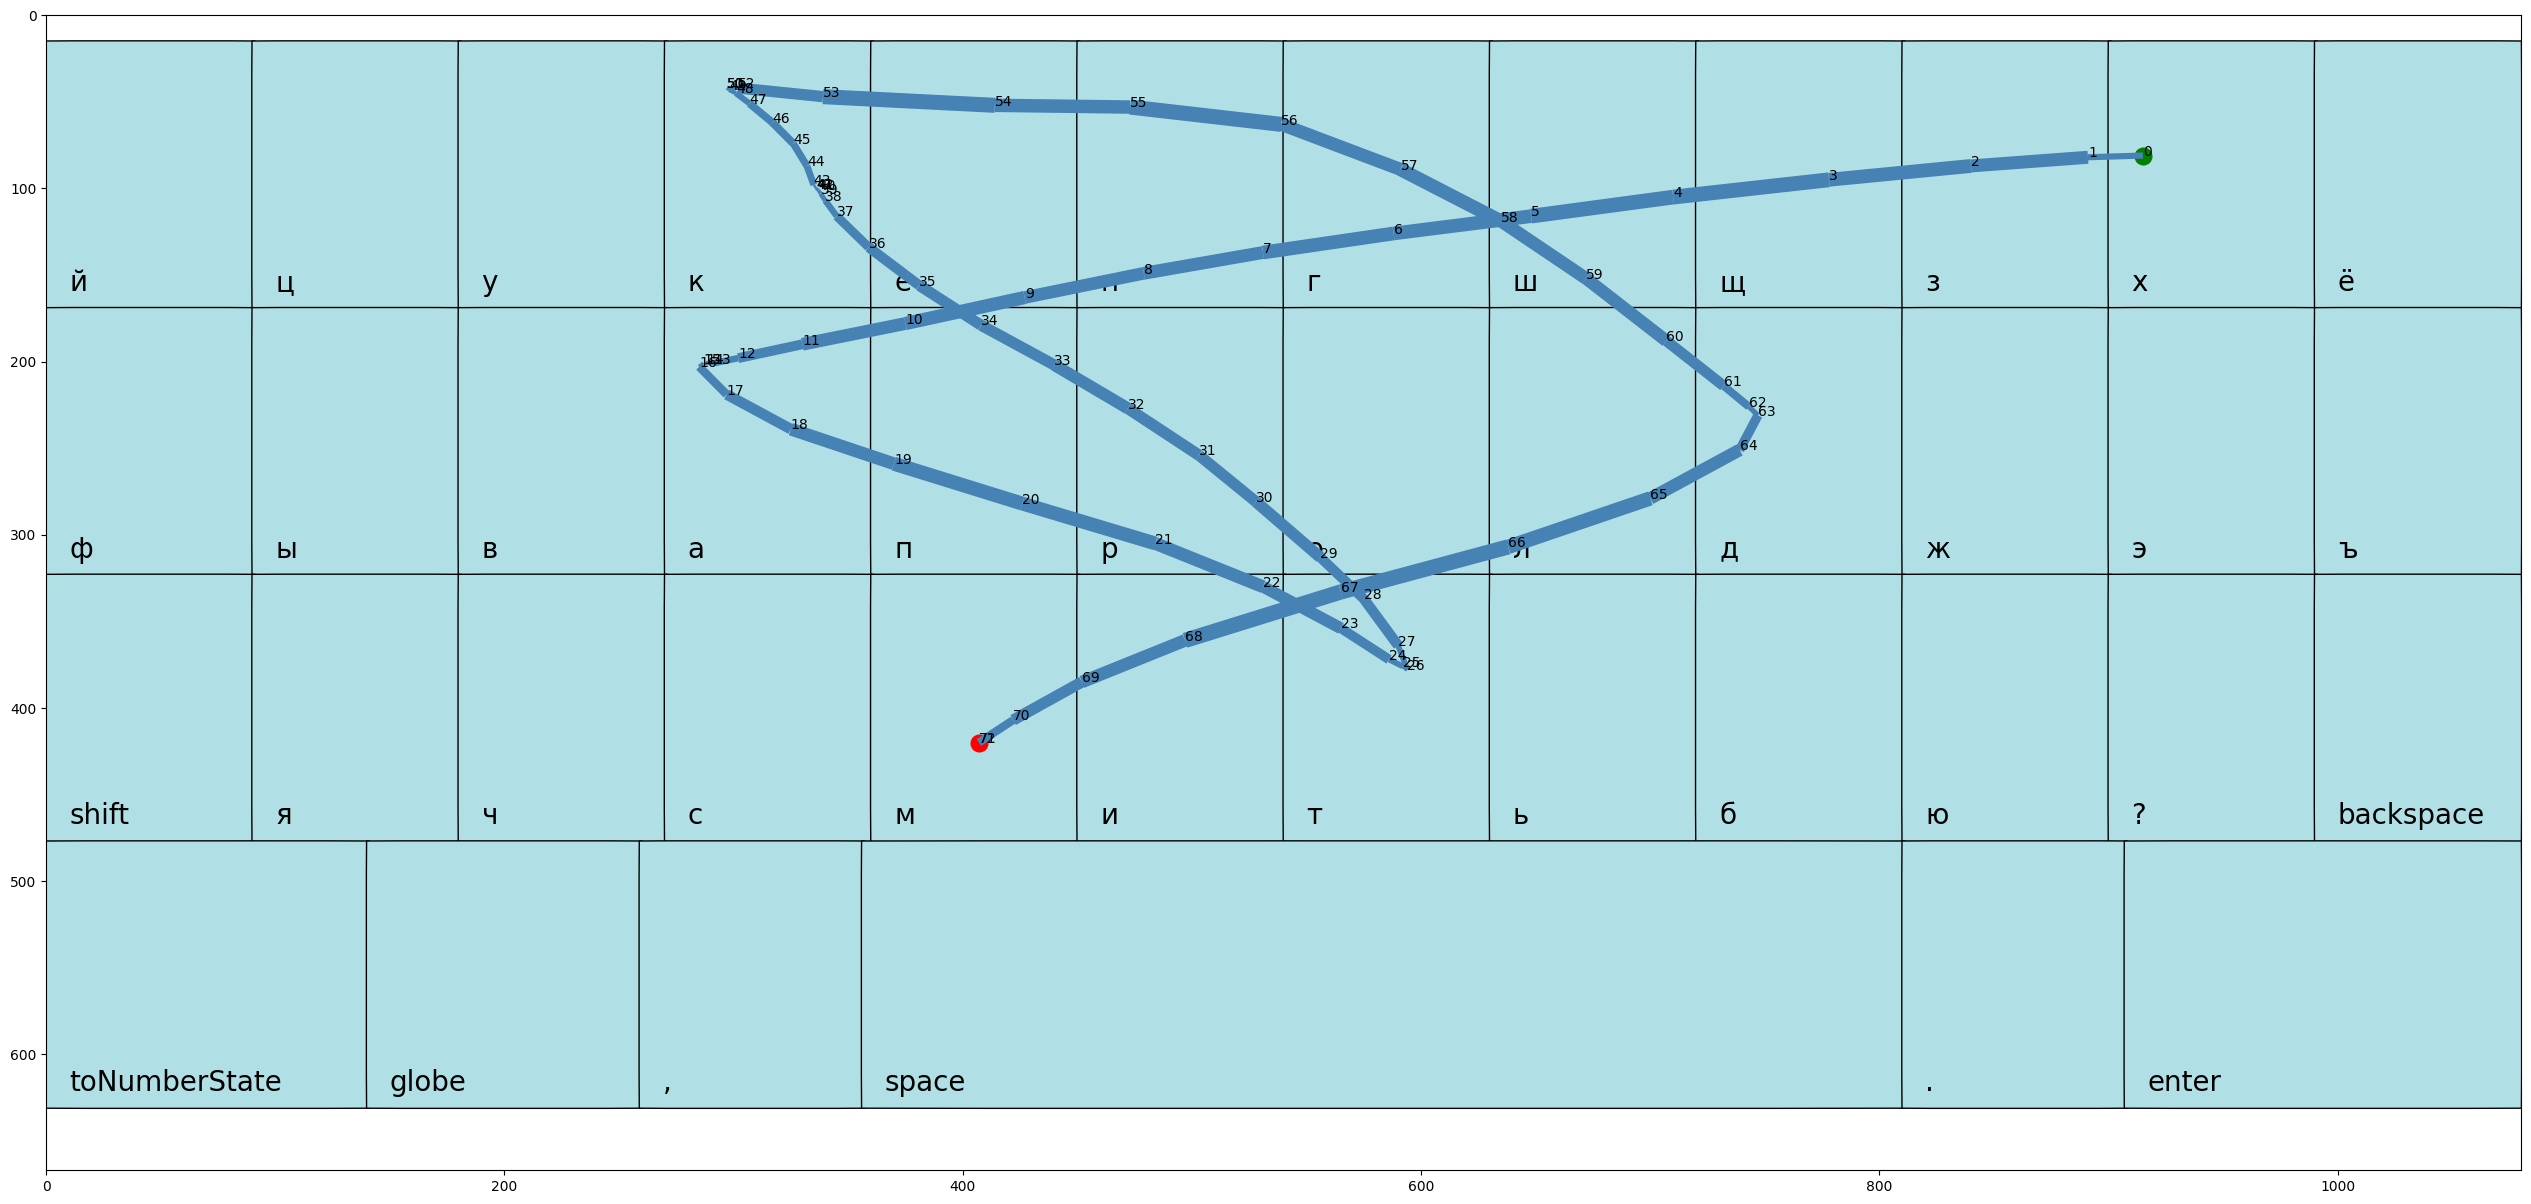

In [13]:
curve_id = 8888
plot_curve(curve_id, df_test_curves, df_test_curves_info, is_test=True)